In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

#from helper2 import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

%load_ext autoreload
%autoreload 2

import torchvision

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from helpers_nn import *
from itertools import islice

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

### MNIST dataset
The MNIST dataset is loaded.

In [4]:
trainset = datasets.MNIST('', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
print("Training and test sets information is displayed.\n\n")
print("Trainset:\n",trainset)
print("Testset:\n",valset)

Training and test sets information is displayed.


Trainset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Testset:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: PATH_TO_STORE_TESTSET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [6]:
print(valloader)
len(valloader)

157

64 images in each batch and each image has a dimension of 28 x 28 pixels


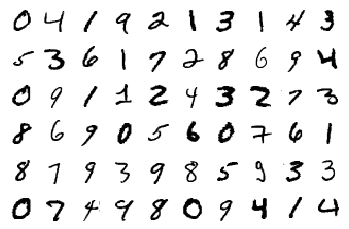

In [7]:
# A subset of a batch is plotted to show a sample of the dataset. 
dataiter = iter(trainloader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Neural Network 

### Model definition
The model is defined, specifying the structure of the neural network.

### Model A: FCNN
Fully connected neural network, with hidden layer structure through vector *hidden_sizes*.

In [8]:
# Input and output sizes and network structure are defined.
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
print(modelA)

# Loss of the model is defined.
criterion = nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Model B: CNN
Convolutional neural network composed of two convolutional layers and two fully connected layers.

In [8]:
# The size of the images is computed.
images,_=dataiter.next()
image_size=images[0].shape[1]
# Using nn.CrossEntropyLoss allows to avoid specifying LogSoftmax as final layer.
criterion = nn.CrossEntropyLoss()
# Depending on the size of the image, a CNN model is built.
modelB=ConvNet(image_size)
print(modelB)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


### Training


In [1]:
from curveball import CurveBall

In [10]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "CurveBall"
optimizer = CurveBall(modelA.parameters(),lr=0.01, momentum=0.9)
time0 = time()
epochs = 9

train_losses, test_losses = optimize(optimizer, epochs, trainloader,valloader, modelA, criterion, method)

Epoch 0
Training loss: 0.3281608868940378
Number Of Images Tested = 10000
Model Accuracy = 0.9363
Test loss: 0.20504195424935714 

Epoch 1
Training loss: 0.09054325389261765
Number Of Images Tested = 10000
Model Accuracy = 0.9443
Test loss: 0.17209732419496793 

Epoch 2
Training loss: 0.05598728117252043
Number Of Images Tested = 10000
Model Accuracy = 0.9534
Test loss: 0.14628538935130853 

Epoch 3
Training loss: 0.039137838295162486
Number Of Images Tested = 10000
Model Accuracy = 0.9571
Test loss: 0.13443864354564197 

Epoch 4
Training loss: 0.028529250367009925
Number Of Images Tested = 10000
Model Accuracy = 0.9637
Test loss: 0.12018045616353963 

Epoch 5
Training loss: 0.021750166300070612
Number Of Images Tested = 10000
Model Accuracy = 0.9662
Test loss: 0.1104794018620115 

Epoch 6
Training loss: 0.01750662153370049
Number Of Images Tested = 10000
Model Accuracy = 0.9661
Test loss: 0.11366108534145791 

Epoch 7
Training loss: 0.013934477851737284
Number Of Images Tested = 10000

In [13]:
def optimize_(optimizer, epochs, trainloader, valloader, model, criterion , method = None ):
    train_losses = []
    test_losses = []
    accuracy = []
    time0 = time()
    
    for e in range(epochs):
        print("Epoch {}".format(e))
        running_loss = 0
        for images, labels in trainloader
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            def closure():
                # Training pass
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                #This is where the model learns by backpropagating, not needed for linesearch
                if loss.requires_grad:
                    loss.backward()
                return loss

            def closure_hf():
                # Training pass
                
                output = model(images)
                loss = criterion(output, labels)
                #This is where the model learns by backpropagating, not needed for linesearch
                if loss.requires_grad:
                    loss.backward(create_graph=True)
                return loss , output
            
            #And optimizes its weights here
            if method== "LBFGS" :
                optimizer.step(closure)
                
            elif method == "HF" :
                optimizer.zero_grad()
                optimizer.step(closure_hf, M_inv=None)
                
            else :
                closure()
                optimizer.step()
                
                
            with torch.no_grad():
                output = model(images)
                loss_ = criterion(output, labels)
            running_loss += loss_.item()

            
        # Compute the test loss
        # we let torch know that we dont intend to call .backward
        
        train_losses.append( running_loss/len(trainloader))
        
        acc = accuracy_test(valloader, model)
        accuracy.append(acc)

        test_loss = 0
        with torch.no_grad():
            model.eval()
            for test_images, test_labels in valloader:

                test_images = test_images.view(test_images.shape[0], -1)

                test_output = model(test_images)
                tloss = criterion(test_output, test_labels)

                test_loss += tloss.item()


        test_losses.append(test_loss/len(valloader))


    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    training_time = (time()-time0)/60

    return test_losses, train_losses

## LBFGS

In [14]:
def LBFGS_optimizer(parameter):
    lr=0.8
    max_iter=4
    max_eval=None
    tolerance_grad=1e-5
    tolerance_change=1e-9
    history_size=10
    line_search_fn='strong_wolfe'
    return torch.optim.LBFGS(parameter, lr, max_iter, max_eval, tolerance_grad, tolerance_change, history_size, line_search_fn)

In [15]:
input_size = 784
output_size = 10
sizes = [input_size,128,64,output_size]

# The model is built
modelA=fully_connected_NN(sizes)
# Loss of the model is defined.
criterion = nn.NLLLoss()

method = "LBFGS"
optimizer = LBFGS_optimizer(modelA.parameters())
time0 = time()
epochs = 9

train_losses, test_losses = optimize_(optimizer, epochs, trainloader,valloader, modelA, criterion, method)

Epoch 0


TypeError: islice() takes no keyword arguments